Can we plot the x2 ellipse model in PPV space? Once we do that, can we scatter in the points for each cloud and try to fit the x2 orbit in PPV space? Any "near" points get assigned 1, any "far get -1. Try to do a best fit match with the +1/-1 streams for different sized CMZs? 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
import matplotlib.collections as mcoll
from scipy.interpolate import NearestNDInterpolator
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u

import lmfit
from lmfit import minimize, Parameters,create_params


In [2]:
plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,b,z,v0,theta,xyzsun,vxyzsun,alpha=0.4):
        self.t     = t
        self.a     = a
        self.b     = b
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.x     = a*cos(t)
        self.y     = -b*sin(t)
        self.z     = self.z0*sin(-2*t + alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(b*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -b*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.05)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)

        
#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.1
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)



In [3]:
def lb_lv_plots(Rings, a, b):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))




    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

    for i in range(0,len(cat_agg)):

        if cat_agg['NF_decision'][i] == 'N':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[0], s=120 )
        if cat_agg['NF_decision'][i] == 'LN':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[1], s=120)
        if cat_agg['NF_decision'][i] == 'U':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[2], s=120)
        if cat_agg['NF_decision'][i] == 'LF':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[3], s=120)
        if cat_agg['NF_decision'][i] == 'F':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[4], s=120)
        if cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='s', s=150, edgecolor='gray', zorder=3, c='k')


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)


    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(cat_tab)):

        if cat_tab['NF_decision'][i] == 'N':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[0], s=120 )
        if cat_tab['NF_decision'][i] == 'LN':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[1], s=120)
        if cat_tab['NF_decision'][i] == 'U':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[2], s=120)
        if cat_tab['NF_decision'][i] == 'LF':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[3], s=120)
        if cat_tab['NF_decision'][i] == 'F':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[4], s=120)
        if cat_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='s', s=150, edgecolor='gray', zorder=3, c='k')






    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    
    ax[0].text(.95, .95, 'a = {:.3f}, b = {:.3f}'.format(a,b), fontsize=13, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [4]:
###Read in data to scatter plot in lbv 
cat_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")


cat_index = cat_tab['leaf_id']
cloud_name = cat_tab['cloud_name']
l = cat_tab['l']
b = cat_tab['b']
v = cat_tab['v']
sigma = cat_tab['sigma']
rad = cat_tab['rad']
NF_decision = cat_tab['NF_decision']
lb_pixel_mask = cat_tab['lb_pixel_mask']

In [5]:
## aggregate table that pulls out the largest mask
## to represent the l,b N/F/U position

cat_group = cat_tab.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]


In [6]:
NF_sig = np.zeros(np.shape(NF_decision))
for i in range(0,len(NF_decision)):
    if NF_decision[i]=='N':
        NF_sig[i] = 0.1
    if NF_decision[i]=='LN':
        NF_sig[i] = 0.5
    if NF_decision[i]=='nan':
        NF_sig[i] = 0.9
    if NF_decision[i]=='U':
        NF_sig[i] = 0.9
    if NF_decision[i]=='LF':
        NF_sig[i] = 0.5
    if NF_decision[i]=='F':
        NF_sig[i] = 0.1

Text(0.5, 0, 'velocity [km/s]')

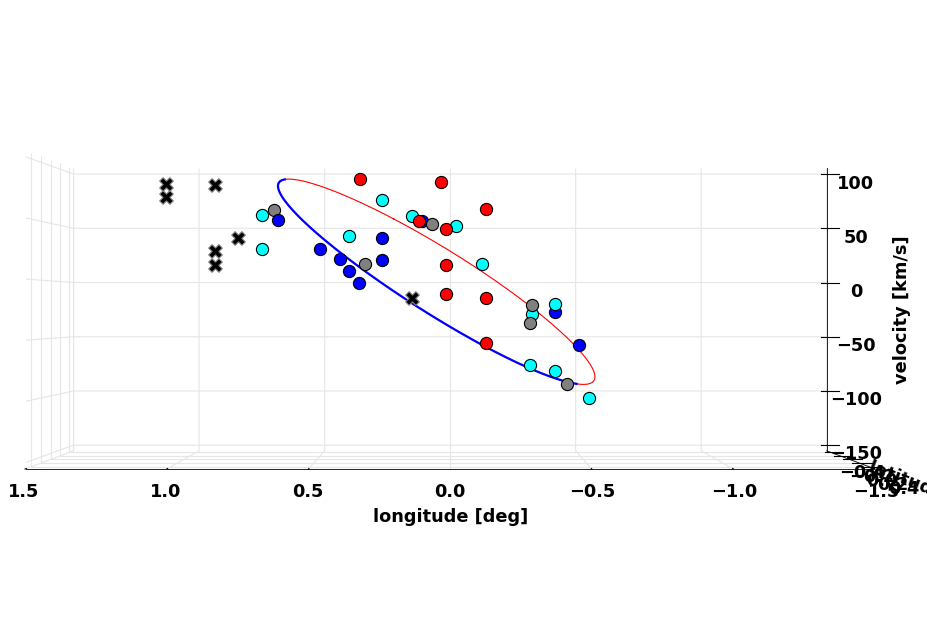

In [7]:
#############################
# define rings
#############################

a_rings = 0.09 # x axis of the rings in kpc
b_rings = 0.055 # y axis of the rings in kpc
z_rings = 0.0125 # height of the ring above/below plane in kpc
v_rings = 130.0 # tangential velocity at initial point
theta_rings = np.radians(25) # inclination of the rings
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings,theta_rings,xyzsun,vxyzsun)

back_ind = np.where(Rings.y>=y_offset)
fore_ind = np.where(Rings.y<=y_offset)




#############################
# PLOT
#############################

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([2, 1, 1, 1]))
fig.set_facecolor('white')
ax.set_facecolor('white')
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))


### Plot Rings ###
ax.plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
ax.plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

# Set the azimuth and elevation angles
ax.view_init(azim=90, elev=0)
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-0.5,0.5)



### Scatter cloud points in lbv ###
color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

for i in range(0,len(cat_tab)):
    
    if cat_tab['NF_decision'][i] == 'N':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[0], s=120 )
    if cat_tab['NF_decision'][i] == 'LN':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[1], s=120 )
    if cat_tab['NF_decision'][i] == 'U':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[2], s=120 )
    if cat_tab['NF_decision'][i] == 'LF':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[3], s=120 )
    if cat_tab['NF_decision'][i] == 'F':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[4], s=120 )
    if cat_tab['NF_decision'][i] == 'nan':
        ax.scatter(l[i],b[i],v[i], marker='X', s=150, edgecolor='gray', zorder=3, c='k')

ax.set_xlabel('longitude [deg]', labelpad=20)
ax.set_ylabel('latitude [deg]', labelpad=10)
ax.set_zlabel('velocity [km/s]', labelpad=10)





Text(0, 0.5, 'latitude [deg]')

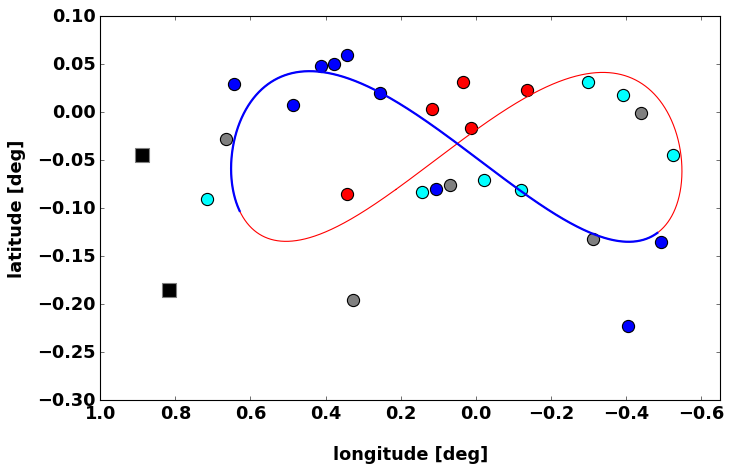

In [8]:
####PLOT#####
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

fig.set_facecolor('white')
ax.set_facecolor('white')





ax.set_xlim(1,-0.65)
ax.set_ylim(-0.3,0.1)



### Scatter cloud points in lbv ###
color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

for i in range(0,len(cat_agg)):
    
    if cat_agg['NF_decision'][i] == 'N':
        ax.scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[0], s=120 )
    if cat_agg['NF_decision'][i] == 'LN':
        ax.scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[1], s=120)
    if cat_agg['NF_decision'][i] == 'U':
        ax.scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[2], s=120)
    if cat_agg['NF_decision'][i] == 'LF':
        ax.scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[3], s=120)
    if cat_agg['NF_decision'][i] == 'F':
        ax.scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[4], s=120)
    if cat_agg['NF_decision'][i] == 'nan':
        ax.scatter(cat_agg['l'][i],cat_agg['b'][i], marker='s', s=150, edgecolor='gray', zorder=3, c='k')

        
### Plot Rings ###
ax.plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
ax.plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


ax.set_xlabel('longitude [deg]', labelpad=20)
ax.set_ylabel('latitude [deg]', labelpad=10)






In [8]:
def distance(x, y, z, x0, y0, z0):
    d_x = x - x0
    d_y = y - y0
    d_z = z - z0
    dis = np.sqrt( d_x**2 + d_y**2 +d_z**2)
    return dis


def min_distance(ringl, ringb, ringv, P):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0,z0] and a curve (x,y,z).
    
    Returns min indexes and distances array.
    """
    # compute distance
    d = distance(np.degrees(ringl), np.degrees(ringb), ringv, P[0], P[1], P[2])

    # find the minima
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d





In [9]:
### create a function that is a continuous distribution between NF on the ring itself
# take the y indices of the ring that are in front of the offset = Near; behind = Far
# values are relative weights in the distribution?
def ring_NF_dist(Rings):
    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    
    back_NF = -((Rings.y[back_ind] - np.nanmin(Rings.y[back_ind])) / (np.nanmax(Rings.y[back_ind]) - np.nanmin(Rings.y[back_ind])))
    fore_NF = ((Rings.y[fore_ind] - np.nanmin(Rings.y[fore_ind])) / (np.nanmax(Rings.y[fore_ind]) - np.nanmin(Rings.y[fore_ind])))

    return back_ind, fore_ind, back_NF, fore_NF
    

In [21]:
## lmfit to l,b,v and weight each point by near/far confidence 
## maybe 0, +0.5, +1 weights in the fit?

# Data is l,b,v

# uncertainty is NFU 
uncertainty = NF_sig

params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': False},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': False},
                       theta_rings={'value': 25  , 'min': 15, 'vary': False}
                          )



In [27]:
len(phi)

360000

In [22]:
def ring_resid(params, l,b,v, uncertainty):
    a_ring=params['a_rings']
    b_rings=params['b_rings']
    z_rings=params['z_rings']
    v_rings=params['v_rings']
    theta_rings=params['theta_rings']
    
    dphi = np.radians(0.001)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
    
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun)
    back_ind, fore_ind, back_NF, fore_NF = ring_NF_dist(Rings)
    
    
    ### for each catalogue point, find the minimum residual between pt and the ellipse
    #   and save the min to array
    min_d_list = []
    for i in range(len(cat_agg)):
        ind, vec = min_distance(Rings.l,Rings.b,Rings.vr, (cat_agg['l'][i],cat_agg['b'][i],cat_agg['v'][i]))
        min_d_list.append(vec[ind])
    
    ### Find how well each point agrees with the N/F degree of the model ellipse
    # 
    
    
    #return an array of all of the residuals/minimum distances to the ellipse?
    return min_d_list
    

In [23]:
out = minimize(ring_resid, params, args=(l,b,v, uncertainty))

In [24]:
out


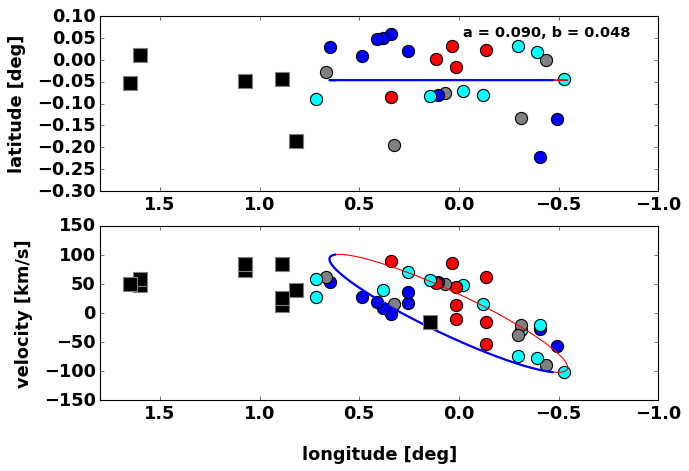

In [70]:
lb_lv_plots(Rings, out.params['a_rings'].value, out.params['b_rings'].value )

Text(0.5, 0, 'velocity [km/s]')

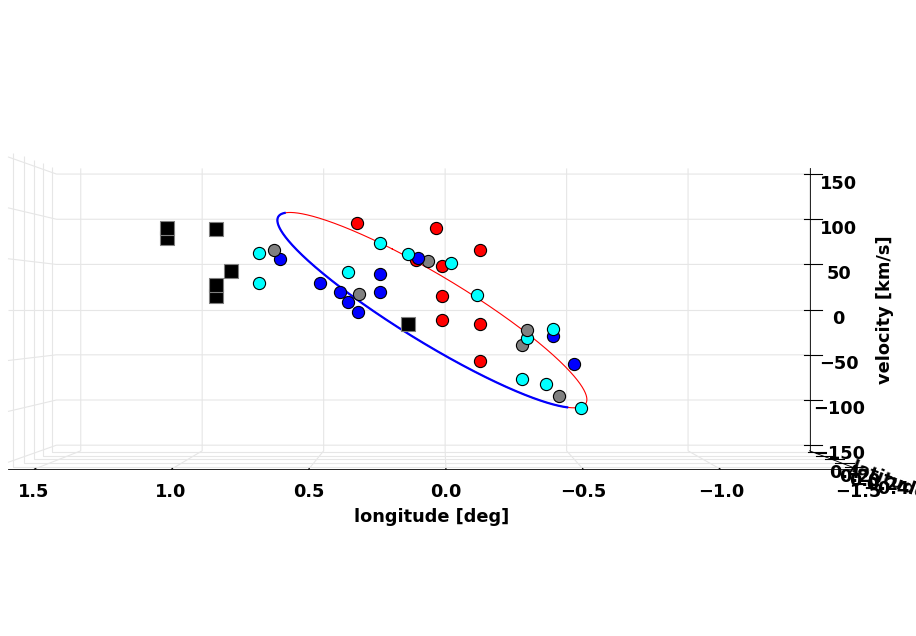

In [43]:
#############################
# define rings
#############################

a_rings =  out.params['a_rings'].value # x axis of the rings in kpc
b_rings =  out.params['b_rings'].value # y axis of the rings in kpc
z_rings = out.params['z_rings'].value # height of the ring above/below plane in kpc
v_rings = out.params['v_rings'].value # tangential velocity at initial point
theta_rings = np.radians(out.params['theta_rings'].value) # inclination of the rings
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings,theta_rings,xyzsun,vxyzsun)

back_ind = np.where(Rings.y>=y_offset)
fore_ind = np.where(Rings.y<=y_offset)


####PLOT#####

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([2, 1, 1, 1]))
fig.set_facecolor('white')
ax.set_facecolor('white')
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))


### Plot Rings ###
ax.plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
ax.plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

# Set the azimuth and elevation angles
ax.view_init(azim=90, elev=0)
ax.set_xlim(-1.5,1.6)
ax.set_ylim(0.5,-0.5)



### Scatter cloud points in lbv ###
color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))

for i in range(0,len(cat_tab)):
    
    if cat_tab['NF_decision'][i] == 'N':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[0], s=120 )
    if cat_tab['NF_decision'][i] == 'LN':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[1], s=120 )
    if cat_tab['NF_decision'][i] == 'U':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[2], s=120 )
    if cat_tab['NF_decision'][i] == 'LF':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[3], s=120 )
    if cat_tab['NF_decision'][i] == 'F':
        ax.scatter(l[i],b[i],v[i], marker='o', c=color_list[4], s=120 )
    if cat_tab['NF_decision'][i] == 'nan':
        ax.scatter(l[i],b[i],v[i], marker='s', s=150, edgecolor='gray', zorder=3, c='k')

ax.set_xlabel('longitude [deg]', labelpad=20)
ax.set_ylabel('latitude [deg]', labelpad=10)
ax.set_zlabel('velocity [km/s]', labelpad=10)





# Set Param Grid instead?

In [32]:
a_grid = np.arange(0.05, 0.3, 0.05)
b_grid = np.arange(0.05, 0.2, 0.05)
z_grid = np.arange(-0.02, 0.02, 0.0025 )
v0_grid = np.arange(130, 155, 1)
theta_grid = np.arange(10,30, 1)

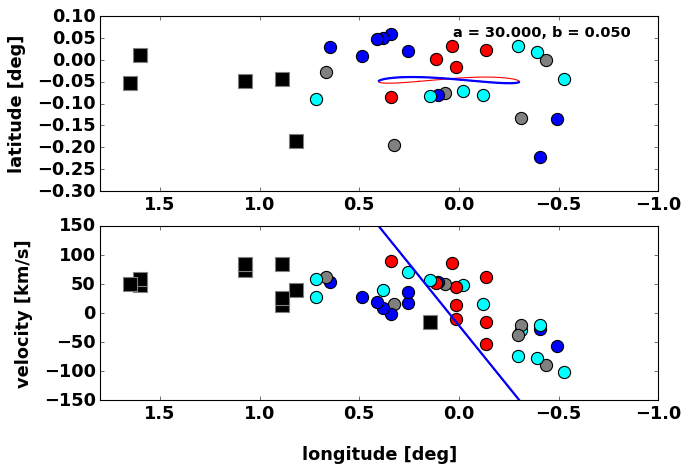

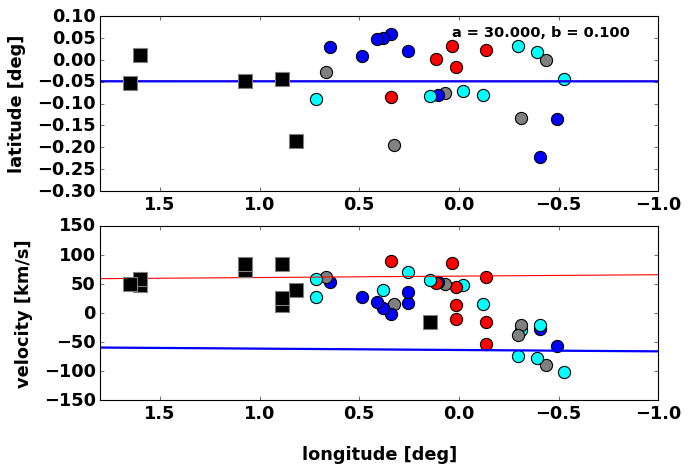

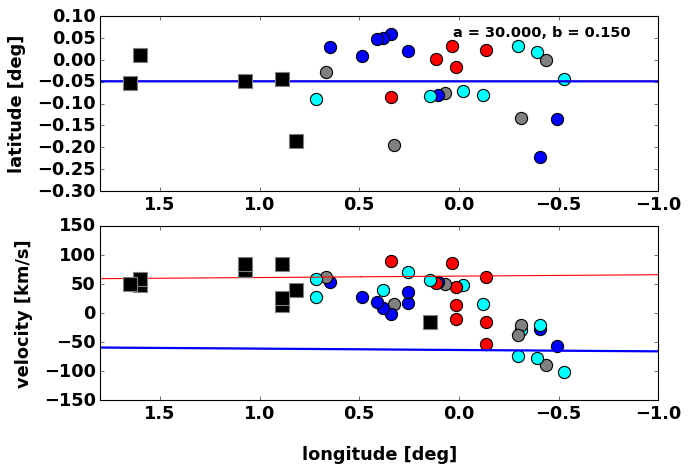

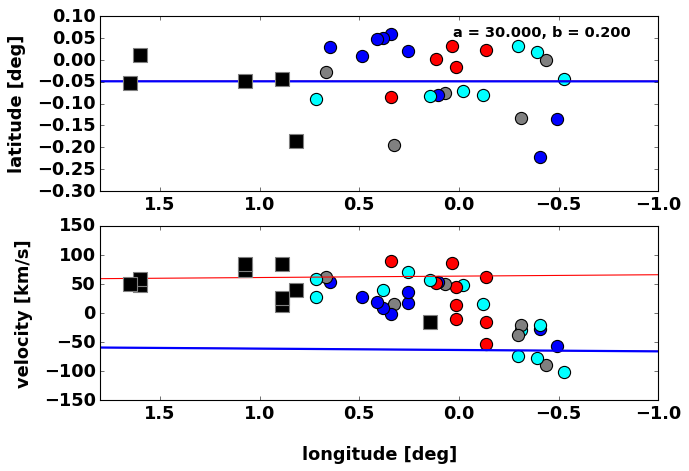

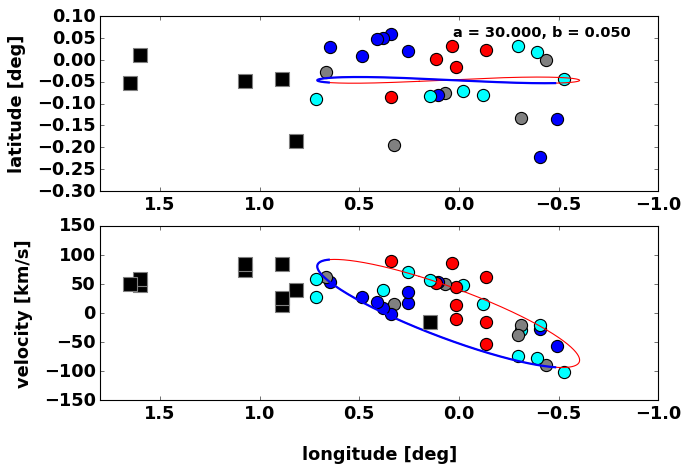

KeyboardInterrupt: 

In [33]:
for i in a_grid:
    for j in b_grid:
        dphi = np.radians(0.001)
        phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
        Rings = Ring(phi,i,j,z_rings,v_rings,theta_rings,xyzsun,vxyzsun)

        back_ind = np.where(Rings.y>=y_offset)
        fore_ind = np.where(Rings.y<=y_offset)
        
        min_d_list = []
        for i in range(len(cat_agg)):
            ind, vec = min_distance(Rings.l,Rings.b,Rings.vr, (cat_agg['l'][i],cat_agg['b'][i],cat_agg['v'][i]))
            min_d_list.append(vec[ind])
        
        lb_lv_plots(Rings,i,j)


In [ ]:
### Possibly redo this with a set param grid, prioritizing testing CMZ sizes
### Make the ring, plot lv and lb separately
### Store the plots

## main point being discussion of larger CMZ sizes and optimized x2 orbit params for those sizes

## Without LOS distances, optmizing the ring fit is too obscure/difficult 